Aufwand in Stunden: 5

In [1]:
import pandas as pd
import random
import numpy as np
import numbers
from copy import deepcopy
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/tesla_stocks.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3006 non-null   object 
 1   Open       3006 non-null   float64
 2   High       3006 non-null   float64
 3   Low        3006 non-null   float64
 4   Close      3006 non-null   float64
 5   Adj Close  3006 non-null   float64
 6   Volume     3006 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 164.5+ KB


# Splitting train and test
A method splits the data according to a parameter train_size. For this method x elements for the provided list are popped and added to the train split. x is determined by train_size times the length of the initial list. Since the indexing of the provided list is done randomly, there is no need to shuffle the lists first.

In [4]:
def split_train_test(X, y, train_size=0.8):
    # X and y dont need to be shuffled as random index
    # is used to append to train and test
    X_copy = X.copy()
    y_copy = y.copy()
    
    train_X = []
    train_y = []
    
    train_size = int(len(X)*train_size)
    
    for i in range(0, train_size):
        pop_idx = random.randint(0, len(X_copy)-1)
        popped_X = X_copy.pop(pop_idx)
        popped_y = y_copy.pop(pop_idx)
        train_X.append(popped_X)
        train_y.append(popped_y)
    
    # return x and y for train and test(= copy)
    return train_X, train_y, X_copy, y_copy
    

In [5]:
# get X and y for splitting
X, y = df.iloc[:, :-1].values.tolist(), df.iloc[:, -1].values.tolist()

In [6]:
init_size = len(X)

In [7]:
# split data -> 80% train, 20% test
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8)

In [8]:
print("Size of x and y for train: {}-{}\nSize of x and y for test: {}-{}".format(len(X_train), len(y_train), len(X_test), len(y_test)))
print("Train size and test size: {}%-{}%".format(len(X_train)/init_size*100, len(X_test)/init_size*100))

Size of x and y for train: 2404-2404
Size of x and y for test: 602-602
Train size and test size: 79.97338656021292%-20.02661343978709%


In [9]:
X_train[:4]

[['2020-09-22', 429.600006, 437.76001, 417.600006, 424.230011, 424.230011],
 ['2014-07-30', 44.383999, 45.919998, 44.208, 45.784, 45.784],
 ['2011-08-01', 5.734, 5.796, 5.642, 5.754, 5.754],
 ['2021-01-28', 820.0, 848.0, 801.0, 835.429993, 835.429993]]

# Discretization method
## Equal width
Train and test set are combined into one array. For each column a different binning process needs to be done. Therefore, we iterate over each column. If the column is numeric, then we continue with discretization, otherwise we skip this column.
Then, we need to calculate the width size for each bin, with the following formula: (max-min)/#bins. Afterwards, a dictionary is created which holds the maximum value for each bin. This dictionary is used to discretize each value for each column. The transformed lists are then returned.

## Equal frequency
Train and test set are combined into one array. For each column a different binning process needs to be done. Therefore, we iterate over each column. If the column is numeric, then we continue with discretization, otherwise we skip this column.
Then, we need to calculate the boundaries for each bin to ensure equal frequency of datapoints in each bin. Therefore, we use one-dimensional interpolation. We need to sort all values in ascending order and use them as y-coordinates. As x-coordinates we use a list with increasing digits starting from 0 to length of list - 1. Then, we interpolate the two points at equal width distances for binning. The interpolated points are the boundaries for equal-frequency binning. A dictionary saves those boundaries with the corresponding bin number and it is used to discretize each value for each column. Source for determining equal-frequency boundaries: https://www.statology.org/equal-frequency-binning-python/

## Lloyd
Train and test set are combined into one array. For each column a different binning process needs to be done. Therefore, we iterate over each column. If the column is numeric, then we continue with discretization, otherwise we skip this column.
Then, we fit a kmeans classifier with the combined train and test data (sklearn -> k is number of bins) and predict each value again to get their bin number. The new bin number needs to be saved again in the corresponding set and column. The transformed lists are then returned.


In [10]:
def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False

In [11]:
def equal_width(train, test, bins):
    comb = np.array(train + test)
    if len(comb) == 0:
        print('Empty sets were provided. Discretization was unsuccessful')
        return train, test
    rows, cols = comb.shape
    
    for i in range(0, cols):
        eq_w = comb[:, i].copy()
        # check if all entries of columns are numeric
        is_float_lst = not all([type(item) == int for item in eq_w])
        if not all([type(item) == int or is_float(item) for item in eq_w]):
            continue
        if is_float_lst:
            eq_w = [float(i) for i in eq_w]
        else:
            eq_w = [int(i) for i in eq_w]
        min_ = min(eq_w)
        max_ = max(eq_w)
        width = (max_ - min_)/bins
        binning = {max_val:discrete for discrete,max_val in zip(range(0, bins),
                                                                np.arange(min_ + width, width*bins+min_+0.1, width))}
        binning.pop(list(binning.keys())[-1])
        binning[max_] = bins-1
        # bin train and test with dictionary
        for j in range(0, len(train)):
            for max_val, discrete in binning.items():
                if train[j][i] <= max_val:
                    train[j][i] = discrete
                    break
        for j in range(0, len(test)):
            for max_val, discrete in binning.items():
                if test[j][i] <= max_val:
                    test[j][i] = discrete
                    break
    return train, test
        
    

In [12]:
def equal_frequency(train, test, bins):
    comb = np.array(train + test)
    if len(comb) == 0:
        print('Empty sets were provided. Discretization was unsuccessful')
        return train, test
    rows, cols = comb.shape
    
    for i in range(0, cols):
        eq_w = comb[:, i].copy()
        # check if all entries of columns are numeric
        is_float_lst = not all([type(item) == int for item in eq_w])
        if not all([type(item) == int or is_float(item) for item in eq_w]):
            continue
        if is_float_lst:
            eq_w = [float(i) for i in eq_w]
        else:
            eq_w = [int(i) for i in eq_w]
        boundaries = np.interp(np.linspace(0, len(eq_w), bins + 1),
                     np.arange(len(eq_w)),
                     np.sort(eq_w))
        boundaries[-1] = boundaries[-1] + 0.1
        binning = {max_val:discrete for discrete,max_val in zip(range(0, bins), boundaries[1:])}
        for j in range(0, len(train)):
            for max_val, discrete in binning.items():
                if train[j][i] < max_val:
                    train[j][i] = discrete
                    break
        for j in range(0, len(test)):
            for max_val, discrete in binning.items():
                if test[j][i] < max_val:
                    test[j][i] = discrete
                    break
    return train, test
        

In [13]:
def lloyd(train, test, bins):
    comb = np.array(train + test)
    if len(comb) == 0:
        print('Empty sets were provided. Discretization was unsuccessful')
        return train, test
    rows, cols = comb.shape
    
    for i in range(0, cols):
        eq_w = comb[:, i].copy()
        # check if all entries of columns are numeric
        is_float_lst = not all([type(item) == int for item in eq_w])
        if not all([type(item) == int or is_float(item) for item in eq_w]):
            continue
        if is_float_lst:
            eq_w = [float(i) for i in eq_w]
        else:
            eq_w = [int(i) for i in eq_w]
        kmeans = KMeans(n_clusters=bins, random_state=0).fit(np.array(eq_w).reshape(-1, 1))
        train_preds = kmeans.predict(np.array(train)[:, i].reshape(-1, 1))
        test_preds = kmeans.predict(np.array(test)[:, i].reshape(-1, 1))
        for j in range(0, len(train)):
            train[j][i] = train_preds[j]
        for j in range(0, len(test)):
            test[j][i] = test_preds[j]
    return train, test


# Function discretizationSelection
Pseudocode is implemented in python.

In [14]:
def discretization_selection(traindata, testdata, discretization_type, bins=5):
    if discretization_type == 1:
        traindata, testdata = equal_width(traindata, testdata, bins)
    elif discretization_type == 2:
        traindata, testdata = equal_frequency(traindata, testdata, bins)
    elif discretization_type == 3:
        traindata, testdata = lloyd(traindata, testdata, bins)
    else:
        print("Wrong discretization type specified...")
    return traindata, testdata

# Discretize dataset and visualize results

## Equal width
For equal width, I use seaborn's histplots and specify the number of bins used for discretization. If it was successful, then untransfromed and transformed data plots should look like the same.

In [29]:
X_train_eq, X_test_eq = discretization_selection(deepcopy(X_train), deepcopy(X_test), 1, bins=5)

Text(0.5, 0.98, 'Equal width approach with 5 bins, one feature (trainset)')

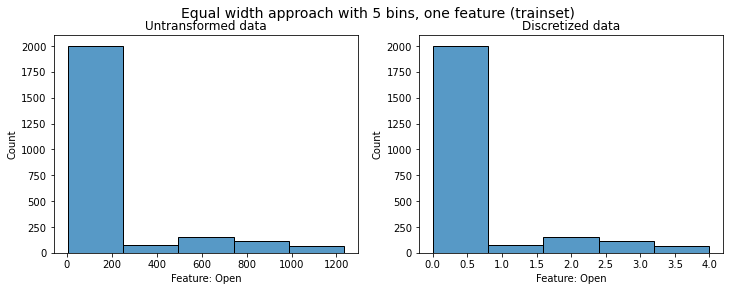

In [30]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(12)
sns.histplot(x=np.array(X_train)[:, 1].astype('float64'),
             stat="count", bins=5, ax = axs[0])
sns.histplot(x=np.array(X_train_eq)[:, 1].astype('uint'),
             stat="count", bins=5, ax=axs[1])
axs[0].set_title('Untransformed data')
axs[0].set_xlabel('Feature: Open')
axs[1].set_title('Discretized data')
axs[1].set_xlabel('Feature: Open')
fig.suptitle('Equal width approach with 5 bins, one feature (trainset)',
             fontsize=14)

Text(0.5, 0.98, 'Equal width approach with 5 bins, one feature (testset)')

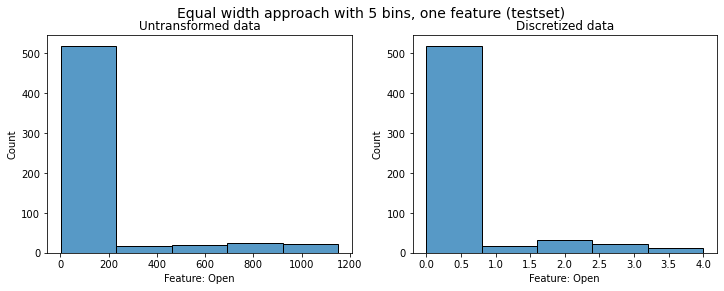

In [31]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(12)
sns.histplot(x=np.array(X_test)[:, 1].astype('float64'),
             stat="count", bins=5, ax = axs[0])
sns.histplot(x=np.array(X_test_eq)[:, 1].astype('uint'),
             stat="count", bins=5, ax=axs[1])
axs[0].set_title('Untransformed data')
axs[0].set_xlabel('Feature: Open')
axs[1].set_title('Discretized data')
axs[1].set_xlabel('Feature: Open')
fig.suptitle('Equal width approach with 5 bins, one feature (testset)',
             fontsize=14)

## Equal frequency
For equal frequency, I plot the used boundaries for discretization. Then, a countplot is of discretized data is visualized, to see that each bin holds approximately the same amount of datapoints.

In [32]:
# based on: https://www.statology.org/equal-frequency-binning-python/
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

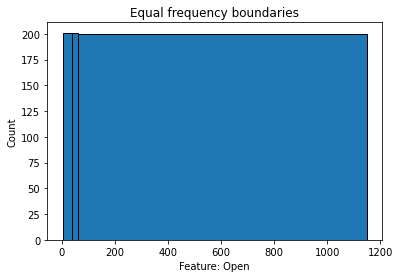

In [33]:
#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(np.array(X_test)[:, 1].astype('float64'),
                            equalObs(np.array(X_test)[:, 1].astype('float64'), 3),
                            edgecolor='black')
plt.title('Equal frequency boundaries')
plt.ylabel('Count')
plt.xlabel('Feature: Open')
plt.show()

In [34]:
X_train_f, X_test_f = discretization_selection(deepcopy(X_train), deepcopy(X_test), 2, bins=3)

Text(0.5, 0.98, 'Equal frequency approach with 3 bins, one feature')

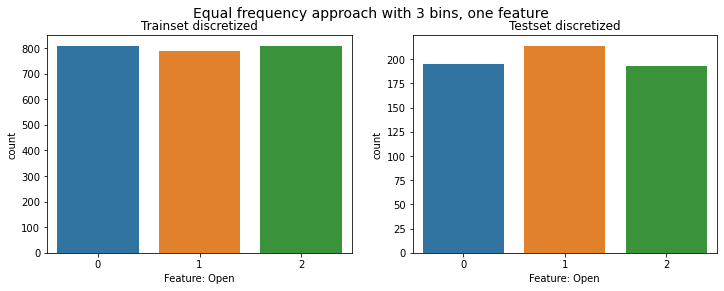

In [35]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(12)
sns.countplot(x=np.array(X_train_f)[:, 1].astype('uint'), ax = axs[0])
sns.countplot(x=np.array(X_test_f)[:, 1].astype('uint'), ax = axs[1])
axs[0].set_title('Trainset discretized')
axs[0].set_xlabel('Feature: Open')
axs[1].set_title('Testset discretized')
axs[1].set_xlabel('Feature: Open')
fig.suptitle('Equal frequency approach with 3 bins, one feature', fontsize=14)

# Lloyd
For the lloyd approach, I plot the numeric values against the assigned classes.

In [36]:
X_train_l, X_test_l = discretization_selection(deepcopy(X_train), deepcopy(X_test), 2, bins=4)

Text(0.5, 0.98, 'Lloyd, one feature, 4 bins')

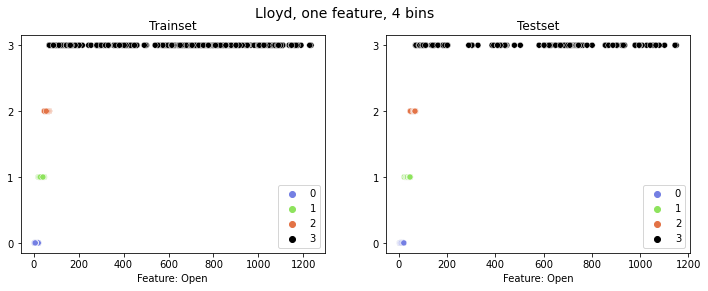

In [37]:
colors = ['#747FE3', '#8EE35D', '#E37346', '#000000']
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(12)
open_test = np.array(X_test_l)[:, 1].astype('uint')
open_train = np.array(X_train_l)[:, 1].astype('uint')
sns.scatterplot(x=np.array(X_test)[:, 1].astype('float64'), y=open_test,
                palette=colors, hue=open_test, ax=axs[1])
sns.scatterplot(x=np.array(X_train)[:, 1].astype('float64'),y=open_train,
                palette=colors, hue=open_train, ax=axs[0])
axs[0].set_title('Trainset')
axs[0].set_xlabel('Feature: Open')
axs[1].set_title('Testset')
axs[1].set_xlabel('Feature: Open')
axs[1].set_yticks([0, 1, 2, 3])
axs[0].set_yticks([0, 1, 2, 3])
fig.suptitle('Lloyd, one feature, 4 bins', fontsize=14)

# Discretized data to csv
We create a dataframe based on the discretized data. The label (Volume), was never discretized, as we splitted it off before the transformation. Furthermore, a label 'Train' is added, which indicates whether the sample is a train or testsample. Also, the date column was never discretized either, as it is no numeric datatype.

Since most of the column values are similar to the ones in their corresponding row, they have very often the same discretized label.

In [38]:
def create_df(X_train, y_train, X_test, y_test):
    np_train = np.array(X_train)
    r, c = np_train.shape
    train_c = np.append(np_train, np.array([y_train]).T, axis=1)
    train_c = np.append(train_c, np.ones((r, 1), dtype=int), axis=1)
    np_test = np.array(X_test)
    r, c = np_test.shape
    test_c = np.append(np_test, np.array([y_test]).T, axis=1)
    test_c = np.append(test_c, np.zeros((r, 1), dtype=int), axis=1)
    comb = np.array(list(train_c) + list(test_c))
    df = pd.DataFrame(comb, columns = ['Date','Open','High','Low',
                                       'Close', 'Adj Close', 'Volume', 'Train'])
    return df

In [39]:
width_df = create_df(X_train_eq, y_train, X_test_eq, y_test)

In [40]:
frequency_df = create_df(X_train_f, y_train, X_test_f, y_test)

In [41]:
lloyd_df = create_df(X_train_l, y_train, X_test_l, y_test)

In [42]:
width_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Train
0,2020-09-22,1,1,1,1,1,79580800,1
1,2014-07-30,0,0,0,0,0,24639000,1
2,2011-08-01,0,0,0,0,0,5824500,1
3,2021-01-28,3,3,3,3,3,26378000,1
4,2010-08-17,0,0,0,0,0,2239500,1


In [43]:
frequency_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Train
0,2020-09-22,2,2,2,2,2,79580800,1
1,2014-07-30,1,1,1,1,1,24639000,1
2,2011-08-01,0,0,0,0,0,5824500,1
3,2021-01-28,2,2,2,2,2,26378000,1
4,2010-08-17,0,0,0,0,0,2239500,1


In [44]:
lloyd_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Train
0,2020-09-22,3,3,3,3,3,79580800,1
1,2014-07-30,1,1,1,1,1,24639000,1
2,2011-08-01,0,0,0,0,0,5824500,1
3,2021-01-28,3,3,3,3,3,26378000,1
4,2010-08-17,0,0,0,0,0,2239500,1


In [45]:
width_df.to_csv('data/equal_width_stocks.csv', sep=';', index=False)
frequency_df.to_csv('data/frequency_stocks.csv', sep=';', index=False)
lloyd_df.to_csv('data/lloyd_stocks.csv', sep=';', index=False)